<a href="https://colab.research.google.com/github/ariso-sac/Sep-2022-NoteBooks/blob/colab-week-2/BestSubmissionTillNow_16_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB,ComplementNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from xgboost import XGBClassifier

In [3]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [4]:
df=pd.read_csv('train1.csv')
df=df.drop('travel_more_than_5_mins',axis=1)
features=df.columns[:-1]
target=df.columns[-1]
X=df[features]
y=df[target]

In [5]:
lb=LabelEncoder().fit(y)
y=lb.transform(y)
l=X.columns.to_list()
order=['offer_expiration(hrs)','age','income_range','temperature','travel_time',
       'restuarant_same_direction_house','western/chinese','children','cooks_regularly',
       'prefer_home_food','visit_restaurant_with_rating_(avg)',
       'visited_ColdDrinks','travelled_more_than_15_mins','resturant_spend_more_than_20',
       'travel_more_than_25_mins','number_visted_bars',
       'number_of_take_aways','restuarant_same_opposite_house',
       'restaurant_spend_greater_than_20','is_foodie'
      ]
for i in order:
    l.remove(i)

In [6]:
X=pd.get_dummies(data=X,columns=l)
enc=OrdinalEncoder()
ord=enc.fit(X)
temp=ord.transform(X)
X=pd.DataFrame(data=temp,columns=X.columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, 
    test_size=0.20,
    random_state=42,
    shuffle=True
)

In [8]:
models = []
models.append(('loreg', LogisticRegression(max_iter=1000,
                                           n_jobs=-1,
                                          #  class_weight='balanced'
                                           )))
models.append(('svc', SVC(
    probability=True
)))
models.append(('GradBoost',  HistGradientBoostingClassifier(
)))
models.append(('HistGradBoost',  GradientBoostingClassifier(
)))
models.append(('KNN',  KNeighborsClassifier(
)))
models.append(('forest',  RandomForestClassifier(
    # class_weight='balanced'
)))
models.append(('naiveBayes_category',CategoricalNB()))
models.append(('naiveBayes_complement',ComplementNB()))
models.append(('xgboost',XGBClassifier()))
models.append(('LinearDiscriminant',LinearDiscriminantAnalysis()))

In [9]:
clf=HistGradientBoostingClassifier(loss='binary_crossentropy',
)

In [10]:
clf.fit(X_train,y_train)

HistGradientBoostingClassifier(loss='binary_crossentropy')

In [11]:
print('Emperical/Training Error',clf.score(X_train,y_train))
print('Genrealisation/Test Error',clf.score(X_test,y_test))

Emperical/Training Error 0.7832979905079269
Genrealisation/Test Error 0.6231825525040388


In [12]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro', n_jobs=-1)
print("Accuracy of %0.3f \n with a \n Standard Deviation of %0.3f" % (scores.mean(), scores.std()))

Accuracy of 0.609 
 with a 
 Standard Deviation of 0.006


In [13]:
param_test1 = {
               'max_leaf_nodes':[20,31,45,50,55],
               'max_depth':[4,5,6,8,None],
               'min_samples_leaf':[10,20,30,40,50,60],
               'warm_start':[True,False]
               }
gsearch1 = GridSearchCV(estimator = clf,
                        param_grid = param_test1, 
                        scoring='f1_macro',cv=5,
                        n_jobs=-1
        ) 
gsearch1.fit(X,y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingClassifier(loss='binary_crossentropy'),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 8, None],
                         'max_leaf_nodes': [20, 31, 45, 50, 55],
                         'min_samples_leaf': [10, 20, 30, 40, 50, 60],
                         'warm_start': [True, False]},
             scoring='f1_macro')

In [14]:
gsearch1.best_score_

0.6145024859185687

In [15]:
gsearch1.best_estimator_

HistGradientBoostingClassifier(loss='binary_crossentropy', max_leaf_nodes=45,
                               min_samples_leaf=40, warm_start=True)

In [16]:
gsearch1.best_params_

{'max_depth': None,
 'max_leaf_nodes': 45,
 'min_samples_leaf': 40,
 'warm_start': True}

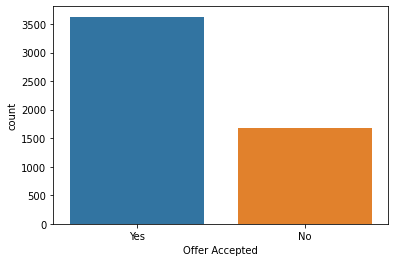

In [17]:
ans=pd.read_csv('test1.csv')
ans=ans.drop('travel_more_than_5_mins',axis=1)
# 
ans=pd.get_dummies(data=ans,columns=l)
temp=ord.transform(ans)
ans=pd.DataFrame(data=temp,columns=X.columns)
# 
out=gsearch1.predict(ans)
out=lb.inverse_transform(out)
submission=pd.DataFrame(columns=['id','Offer Accepted'])
submission['id']=[i for i in range(len(ans))]
submission['Offer Accepted']=out
sns.countplot(x=submission['Offer Accepted'])

In [18]:
submission.to_csv('submission.csv',index=False)